<a href="https://www.kaggle.com/code/duaanaz/face-recognition?scriptVersionId=252529943" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# *Face Recognition Project*

In [1]:
# Load important libraries
import os
import cv2
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from skimage.feature import local_binary_pattern
from sklearn.decomposition import PCA

# Set the plotting style
plt.style.use('ggplot')


In [2]:
# Load pre-trained Haar Cascade classifiers for face, eyes, smile, and nose detection

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_eye.xml")
smile_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_smile.xml")
# nose_cascade = cv2.CascadeClassifier(os.path.expanduser("~/haarcascade_mcs_nose.xml"))


In [3]:
base_path = '../input/students-images/'
student_ids= sorted(os.listdir(base_path))

# Exploratory Data Analysis
# Data Framing

In [4]:
# Make data frame
df = []
for std_id in student_ids:
    paths = sorted(glob(os.path.join(base_path,std_id,std_id,'*.jpg'))) 
    for p in paths:
        img = cv2.imread(p)
        if img is None:
            print("there is no image")
            continue
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        df.append({
            'student_id': std_id,
            'path': p,
            'height': img.shape[0],
            'width': img.shape[1],
            'aspect_ratio': img.shape[1] / img.shape[0],
            'brightness': np.mean(gray),
            'contrast': np.std(gray),
            'blur_score': cv2.Laplacian(gray, cv2.CV_64F).var()
        })

# Convert the list to a DataFrame
df = pd.DataFrame(df)

# print data frame
print(df)


     student_id                                            path  height  \
0            01  ../input/students-images/01/01/frame_00000.jpg    1280   
1            01  ../input/students-images/01/01/frame_00001.jpg    1280   
2            01  ../input/students-images/01/01/frame_00002.jpg    1280   
3            01  ../input/students-images/01/01/frame_00003.jpg    1280   
4            01  ../input/students-images/01/01/frame_00004.jpg    1280   
...         ...                                             ...     ...   
3831         11  ../input/students-images/11/11/frame_00309.jpg    1280   
3832         11  ../input/students-images/11/11/frame_00310.jpg    1280   
3833         11  ../input/students-images/11/11/frame_00311.jpg    1280   
3834         11  ../input/students-images/11/11/frame_00312.jpg    1280   
3835         11  ../input/students-images/11/11/frame_00313.jpg    1280   

      width  aspect_ratio  brightness   contrast  blur_score  
0       720        0.5625  126.00658

# Assessing Data Quantity

Number of images per student:
student_id
01    368
02    312
03    310
04    342
05    295
06    274
07    512
08    382
09    318
10    441
11    282
Name: count, dtype: int64


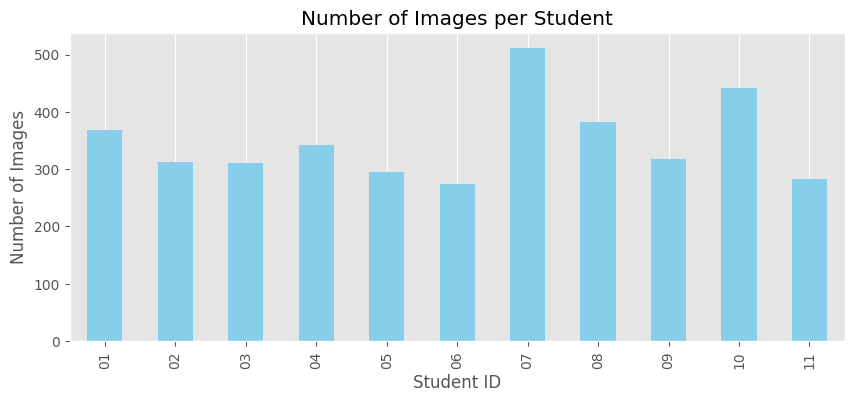

In [5]:
# Print number of images per student
print("Number of images per student:")
print(df['student_id'].value_counts().sort_index())

# Visualizations of: 
# No. of Images per student 
plt.figure(figsize=(10, 4))
df['student_id'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title("Number of Images per Student")
plt.xlabel("Student ID")
plt.ylabel("Number of Images")
plt.grid(axis='y')
plt.show()

# *Face Detection and Cropping with Grayscale Conversion*

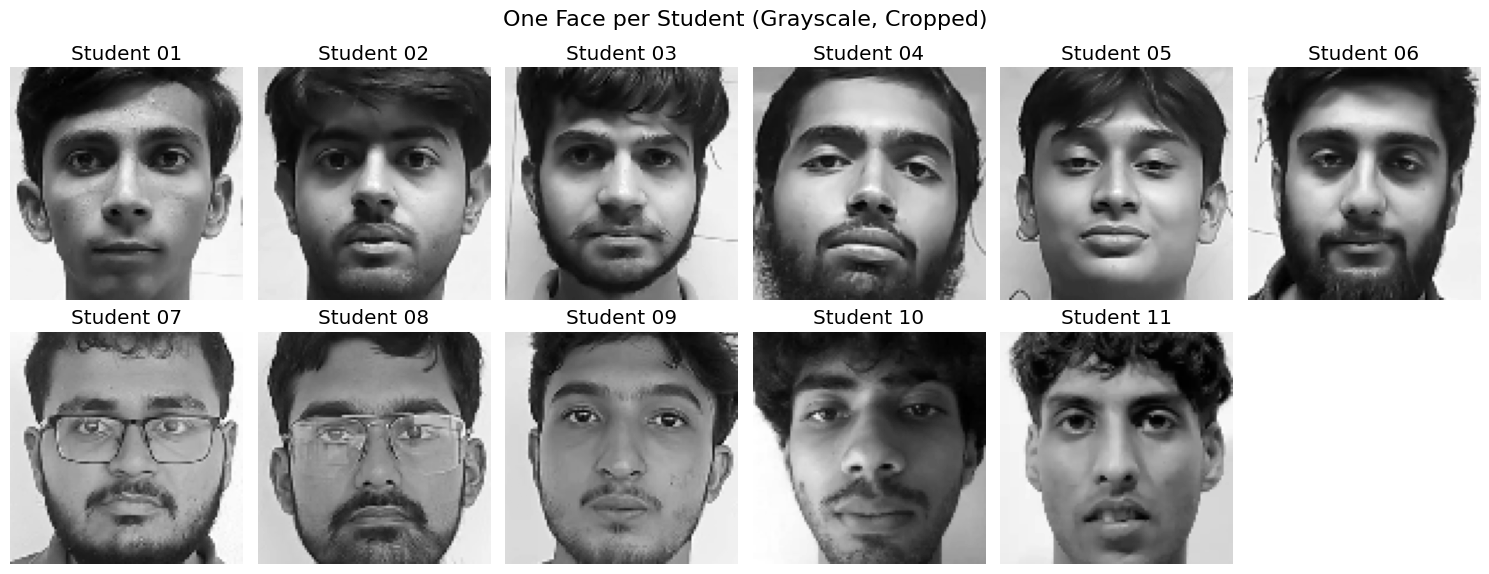

In [6]:
# Visualize 1 face per student
plt.figure(figsize=(15, 6))

for i, sid in enumerate(sorted(df['student_id'].unique())):
    # Get first image path for each student
    sample_row = df[df['student_id'] == sid].iloc[0]
    path = sample_row['path']
    
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to Grayscale
    faces = face_cascade.detectMultiScale(gray, 1.1, 5)

    # Try detecting face
    if len(faces) > 0:
        (x, y, w, h) = faces[0]
        face = gray[y:y+h, x:x+w]
        face = cv2.resize(face, (100, 100))
    else:
        face = cv2.resize(gray, (100, 100))  # fallback

    # Show extracted face
    plt.subplot(2, 6, i+1)
    plt.imshow(face,cmap='gray')
    plt.title(f"Student {sid}")
    plt.axis('off')

plt.suptitle("One Face per Student (Grayscale, Cropped)", fontsize=16)
plt.tight_layout()
plt.show()

# Face Detection Coverage

In [7]:
detected_faces = 0
for p in df['path']:
    img = cv2.imread(p)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 5)
    if len(faces) > 0:
        detected_faces += 1

print(f"Faces Detected: {detected_faces} / {len(df)}")

Faces Detected: 3230 / 3836


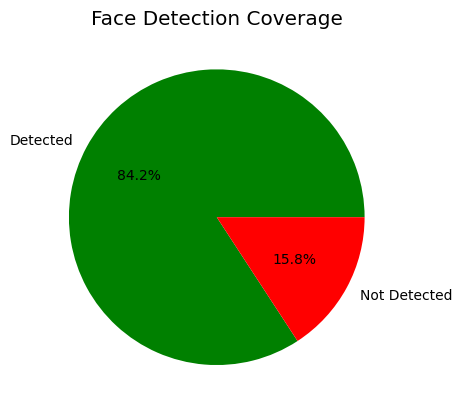

In [8]:
# pie chart
plt.pie([detected_faces, len(df)-detected_faces], 
        labels=["Detected", "Not Detected"], 
        autopct='%1.1f%%', colors=['green', 'red'])
plt.title("Face Detection Coverage")
plt.show()

# Image Quality Analysis
# Aspect Ratio Insight

<Figure size 1000x400 with 0 Axes>

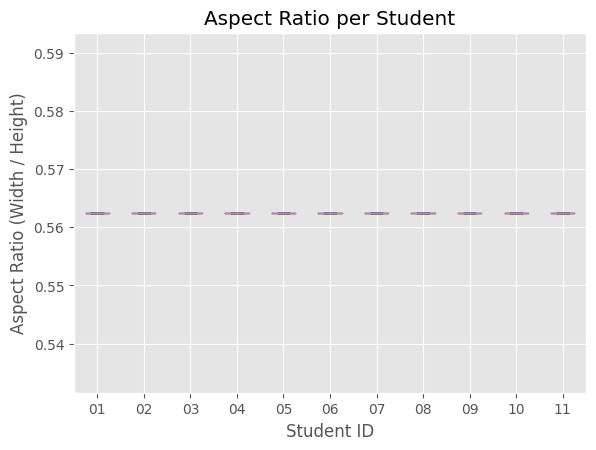

In [9]:
# Aspect Ratio per image
plt.figure(figsize=(10, 4))
df.boxplot(column='aspect_ratio', by='student_id')
plt.title("Aspect Ratio per Student")
plt.suptitle("")
plt.xlabel("Student ID")
plt.ylabel("Aspect Ratio (Width / Height)")
plt.grid(True)
plt.show()

# Bright vs Contrast Insight

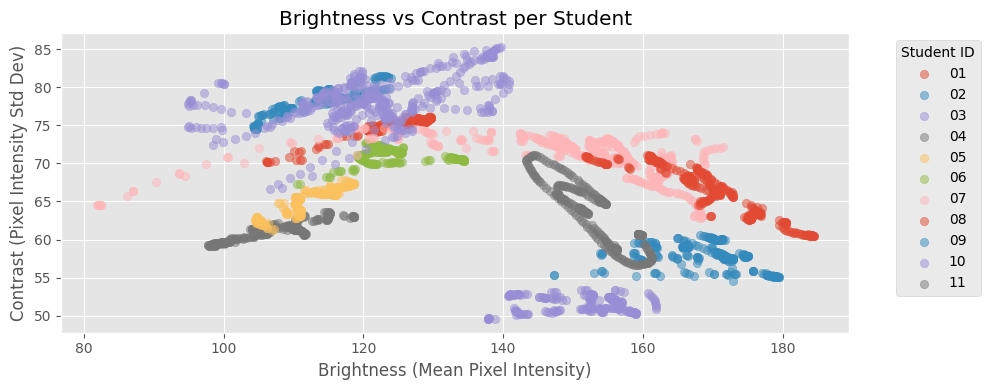

In [10]:
# Brightness vs Contrast
plt.figure(figsize=(10, 4))
for std_id in sorted(df['student_id'].unique()):
    sub = df[df['student_id'] == std_id]
    plt.scatter(sub['brightness'], sub['contrast'], label=std_id, alpha=0.5)

plt.xlabel("Brightness (Mean Pixel Intensity)")
plt.ylabel("Contrast (Pixel Intensity Std Dev)")
plt.title("Brightness vs Contrast per Student")
plt.legend(title="Student ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Sharpness of the Image

<Figure size 1000x400 with 0 Axes>

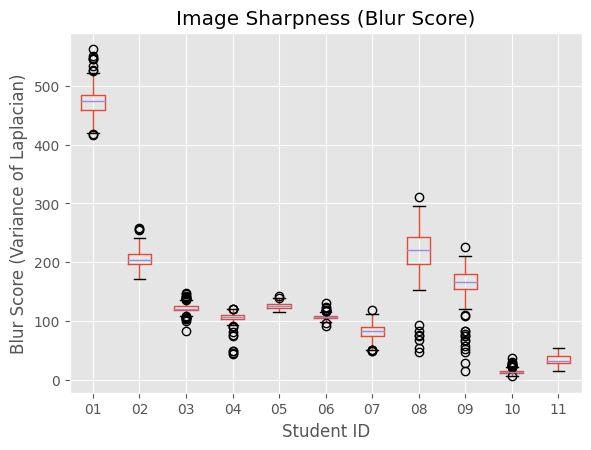

In [11]:
# Blur Score of Images
plt.figure(figsize=(10, 4))
df.boxplot(column='blur_score', by='student_id')
plt.title("Image Sharpness (Blur Score)")
plt.suptitle("")
plt.xlabel("Student ID")
plt.ylabel("Blur Score (Variance of Laplacian)")
plt.grid(True)
plt.show()

# Size Distribution

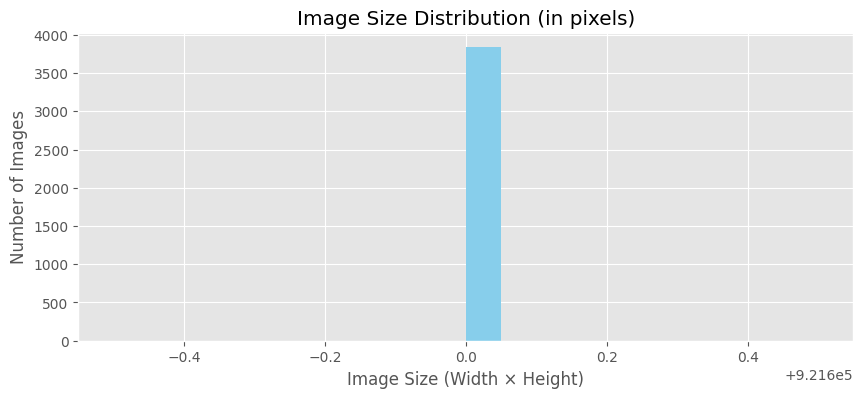

In [12]:
# Image size distribution
plt.figure(figsize=(10, 4))
plt.hist(df['width'] * df['height'], bins=20, color='skyblue')
plt.title("Image Size Distribution (in pixels)")
plt.xlabel("Image Size (Width × Height)")
plt.ylabel("Number of Images")
plt.grid(True)
plt.show()



# Feature Extraction:
# HAAR Cascade Facial Features Detection

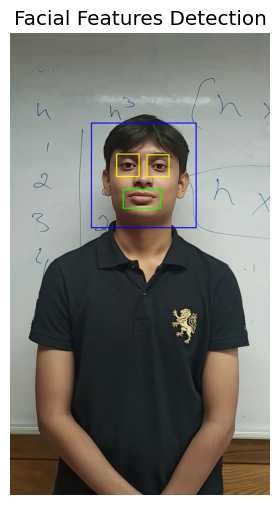

In [13]:
# Load image
sample_path = df.iloc[1450]['path']
img = cv2.imread(sample_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Detect face
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
    
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    
    # Eyes
    eyes = eye_cascade.detectMultiScale(roi_gray, 1.1, 10)
    for (ex, ey, ew, eh) in eyes:
        cv2.rectangle(roi_color, (ex, ey), (ex+ew, ey+eh), (0, 255, 255), 2)
        
    # Smile
    smiles = smile_cascade.detectMultiScale(roi_gray, 1.7, 22)
    for (sx, sy, sw, sh) in smiles:
        cv2.rectangle(roi_color, (sx, sy), (sx+sw, sy+sh), (0, 255, 0), 2)
    
    # # Nose
    # if not nose_cascade.empty():
    #     noses = nose_cascade.detectMultiScale(roi_gray, 1.3, 5)
    #     for (nx, ny, nw, nh) in noses:
    #         cv2.rectangle(roi_color, (nx, ny), (nx+nw, ny+nh), (255, 0, 255), 2)

# Show image using matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Facial Features Detection")
plt.axis('off')
plt.show()

# Edge Detection Using HOG

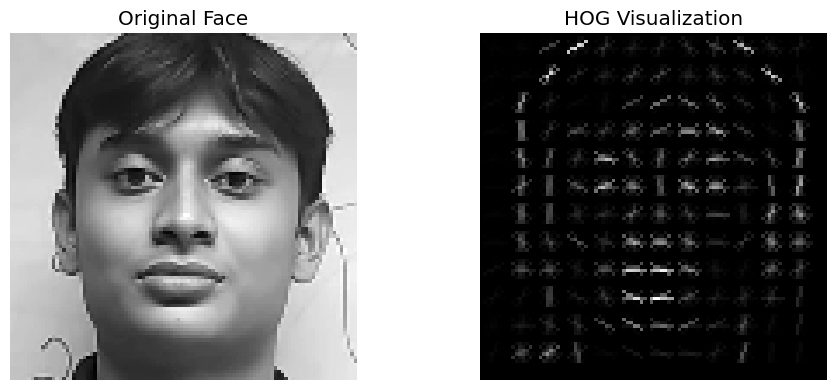

In [14]:
# --- HOG Visualization ---

# Pick one example face
sample_path = df.iloc[1450]['path']
img = cv2.imread(sample_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.1, 5)

(x, y, w, h) = max(faces, key=lambda r: r[2]*r[3])
face = gray[y:y+h, x:x+w]
face = cv2.resize(face, (100, 100))
norm = face.astype('float32') / 255.0

# Extract HOG features and image
features, hog_image = hog(norm, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                          visualize=True, feature_vector=True)

# Enhance contrast
hog_image = exposure.rescale_intensity(hog_image, in_range=(0, 10))

# Original Face
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(norm, cmap='gray')
plt.title("Original Face")
plt.axis('off')

# Hog
plt.subplot(1,2,2)
plt.imshow(hog_image, cmap='gray')
plt.title("HOG Visualization")
plt.axis('off')
plt.tight_layout()
plt.show()

# Using LBP (Local Binary Pattern)

/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


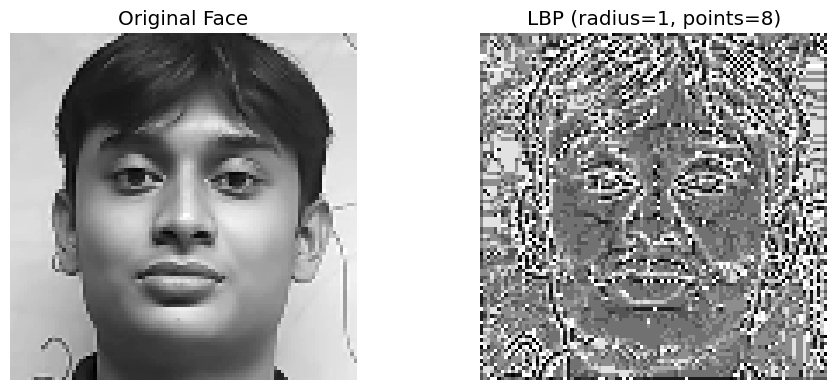

In [15]:
# Parameters
radius = 1
n_points = 8 * radius
method = 'uniform'

# Load a sample image from DataFrame
sample_path = df.iloc[1450]['path']
img = cv2.imread(sample_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Detect face
faces = face_cascade.detectMultiScale(gray, 1.1, 5)
if len(faces) > 0:
    (x, y, w, h) = faces[0]
    face = gray[y:y+h, x:x+w]
else:
    face = gray

# Resize and normalize
face = cv2.resize(face, (100, 100)).astype("float32") / 255.0

# Compute LBP
lbp = local_binary_pattern(face, n_points, radius, method=method)

# Rescale LBP image for better visibility
lbp_rescaled = exposure.rescale_intensity(lbp, out_range=(0, 255)).astype('uint8')

# --- Plot ---
plt.figure(figsize=(10, 4))

# Original face
plt.subplot(1, 2, 1)
plt.imshow(face, cmap='gray')
plt.title("Original Face")
plt.axis("off")

# LBP image
plt.subplot(1, 2, 2)
plt.imshow(lbp_rescaled, cmap='gray')
plt.title(f"LBP (radius={radius}, points={n_points})")
plt.axis("off")

plt.tight_layout()
plt.show()


# Extracting Feature for training + Data Splitting

In [16]:
# Data Splitting - Train&Test
X_train, X_test, y_train, y_test = [], [], [], []
le = LabelEncoder()
# Parameters for LBP
radius = 1
n_points = 8 * radius
print("Feature extraction HOG + LBP...")
for std_id in student_ids:
    features = []
    paths = sorted(glob(os.path.join(base_path, std_id,std_id, '*.jpg')))
    for p in paths:
        img = cv2.imread(p)
        if img is None:
            continue
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 5)
        if len(faces) == 0:
            continue
        x, y, w, h = max(faces, key=lambda r: r[2] * r[3])
        face = gray[y:y + h, x:x + w]
        if np.var(face) < 100:
            continue
        face = cv2.resize(face, (100, 100)).astype('float32') / 255.0

        # HOG Feature extraction
        hog_feat = hog(face, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)

        # LBP extraction
        lbp = local_binary_pattern(face, n_points, radius, method='uniform')
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points+3), range=(0, n_points+2))
        lbp_hist = lbp_hist.astype("float32")
        lbp_hist /= (lbp_hist.sum() + 1e-6)  # Normalize

        # Combine HOG + LBP
        combined = np.hstack([hog_feat, lbp_hist])
        features.append(combined)
    
    if len(features) >= 2:
        a, b = train_test_split(features, test_size=0.2, random_state=42)
        X_train += a
        X_test += b
        y_train += [std_id] * len(a)
        y_test += [std_id] * len(b)

# Encode the labels
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))

Feature extraction HOG + LBP...
Training samples: 2580
Testing samples: 650


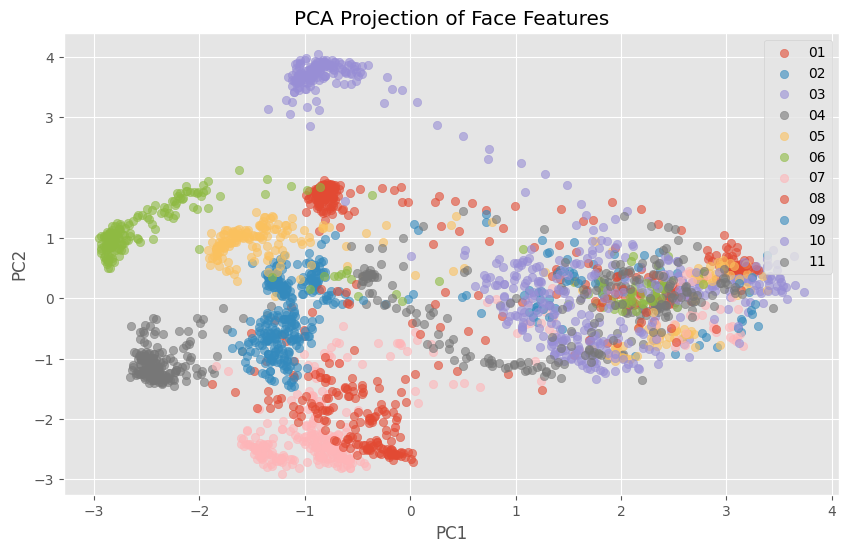

In [17]:
# Stack feature vectors (Training)
X_all = np.vstack((X_train))
y_all = np.hstack((y_train))

y_all_enc = le.fit_transform(y_all)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_all)

# Visualize
plt.figure(figsize=(10, 6))
for label in np.unique(y_all_enc):
    idx = y_all_enc == label
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=le.inverse_transform([label])[0], alpha=0.6)
plt.title("PCA Projection of Face Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()

# Feature Array

In [18]:
# One sample array of train data
print("Sample feature array: " ,X_train[0])
print("The encoder/label: ", y_train[0])
print("Size of the feature array / Number of features in an image: " ,len(X_train[0]))

Sample feature array:  [0.35979602 0.35979602 0.11156549 ... 0.0741     0.114      0.097     ]
The encoder/label:  01
Size of the feature array / Number of features in an image:  4366


# Model Training

In [19]:
# Model Training
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth=14)
model.fit(X_train, y_train_enc)
print("Training complete.")

Training complete.


# Model Evaluation

In [20]:
# --- Evaluation ---

y_train_pred = model.predict(X_train)
acc = accuracy_score(y_train_enc, y_train_pred)
print(f"Train Accuracy: {acc:.2%}")

y_pred = model.predict(X_test)
acc = accuracy_score(y_test_enc, y_pred)
print(f"Test Accuracy: {acc:.2%}")

Train Accuracy: 95.27%
Test Accuracy: 87.38%


# Confusion Matrix

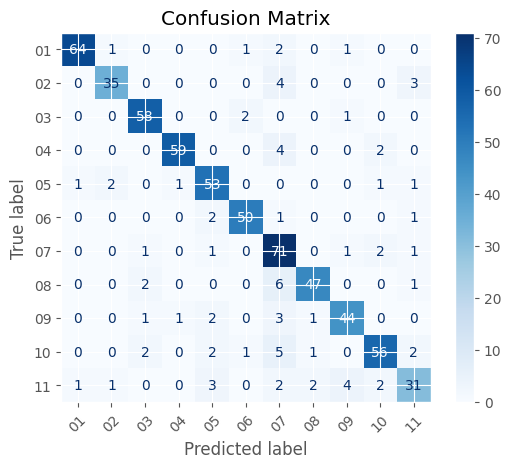

In [21]:
# Confusion Matrix
cm = confusion_matrix(y_test_enc, y_pred)
ConfusionMatrixDisplay(cm, display_labels=le.classes_).plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

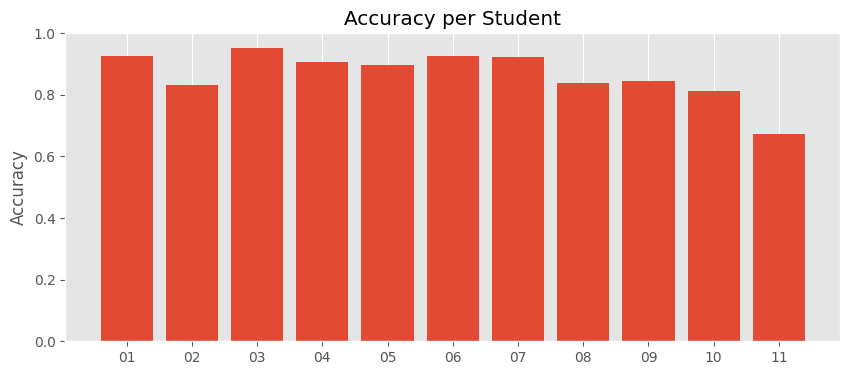

In [22]:
class_accuracy = cm.diagonal() / cm.sum(axis=1)

plt.figure(figsize=(10,4))
plt.bar(le.classes_, class_accuracy)
plt.title("Accuracy per Student")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()


In [23]:
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

          01       0.97      0.93      0.95        69
          02       0.90      0.83      0.86        42
          03       0.91      0.95      0.93        61
          04       0.97      0.91      0.94        65
          05       0.84      0.90      0.87        59
          06       0.93      0.93      0.93        54
          07       0.72      0.92      0.81        77
          08       0.92      0.84      0.88        56
          09       0.86      0.85      0.85        52
          10       0.89      0.81      0.85        69
          11       0.78      0.67      0.72        46

    accuracy                           0.87       650
   macro avg       0.88      0.87      0.87       650
weighted avg       0.88      0.87      0.87       650



# Classification Report

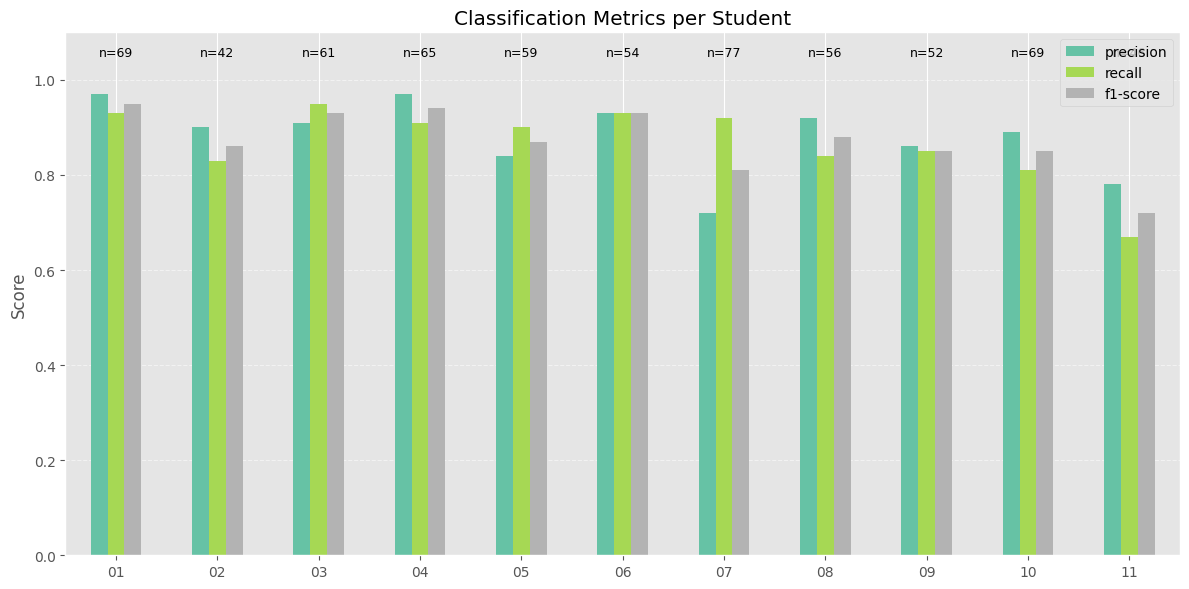

In [24]:
# Generate the classification report dictionary
report_dict = classification_report(y_test_enc, y_pred, target_names=le.classes_, output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Keep only student IDs
report_df = report_df[report_df.index.isin(le.classes_)]

# Round for display
report_df[['precision', 'recall', 'f1-score']] = report_df[['precision', 'recall', 'f1-score']].round(2)

# Plotting with support as annotation
ax = report_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(12, 6), colormap='Set2')
plt.title("Classification Metrics per Student")
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=0)

# Add support (sample count) as labels above each group
for i, (idx, row) in enumerate(report_df.iterrows()):
    support = int(row['support'])
    plt.text(i, 1.05, f'n={support}', ha='center', fontsize=9, color='black')

plt.tight_layout()
plt.legend(loc='upper right')
plt.show()

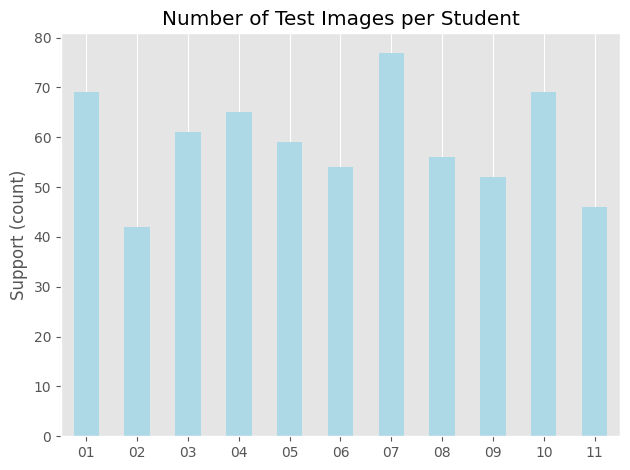

In [25]:
report_df['support'].plot(kind='bar', color='lightblue')
plt.title("Number of Test Images per Student")
plt.ylabel("Support (count)")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Save the Model and Encoder

In [26]:
import joblib
joblib.dump(model, "face_model.pkl")
joblib.dump(le, "label_encoder.pkl")
print("Saved")

Saved
